In [31]:

# installing mediapipe to use it for face detection 
%%capture
!pip install mediapipe



In [2]:
# unzip all files contains in AFLW2000
%%capture
!unzip /content/drive/MyDrive/AFLW2000-3D.zip

In [3]:

# environmet instablish 
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV 

In [4]:
# Getting all  matlab path file for each photot
%%capture
mylist_mat = sorted([str(Path(f))for f in glob.glob("/content/AFLW2000/*.mat")])

In [5]:
# Getting all photos' path 
%%capture
mylist_img=sorted([str(Path(f))for f in glob.glob("/content/AFLW2000/*.jpg")] )

In [6]:
# impelemnt a function to draw axis of yaw ,pitch ,roll on the image 
def draw_axis(img,pitch, yaw,  roll, tdx=None, tdy=None, size = 100):
  yaw=-yaw

  if tdx != None and tdy != None:
      tdx = tdx
      tdy = tdy
  else:
      height, width = img.shape[:2]
      tdx = width / 2
      tdy = height / 2

  # X-Axis pointing to right. drawn in red
  x1 = size * (cos(yaw) * cos(roll)) + tdx
  y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

  # Y-Axis | drawn in green
  #        v
  x2 = size * (-cos(yaw) * sin(roll)) + tdx
  y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

  # Z-Axis (out of the screen) drawn in blue
  x3 = size * (sin(yaw)) + tdx
  y3 = size * (-cos(yaw) * sin(pitch)) + tdy

  cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
  cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
  cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

  return img

In [7]:
# Perparing string array to hold feature and output names 
x="X"
y="Y"
# Naming points in DF 
columns=[]
for i in range(468):
  columns.append(x+"_"+str(i))
for i in range(468):
  columns.append(y+"_"+str(i))
# Naming angles in DF 
columns.extend(["Pitch","Yaw","Roll"])
columns

['X_0',
 'X_1',
 'X_2',
 'X_3',
 'X_4',
 'X_5',
 'X_6',
 'X_7',
 'X_8',
 'X_9',
 'X_10',
 'X_11',
 'X_12',
 'X_13',
 'X_14',
 'X_15',
 'X_16',
 'X_17',
 'X_18',
 'X_19',
 'X_20',
 'X_21',
 'X_22',
 'X_23',
 'X_24',
 'X_25',
 'X_26',
 'X_27',
 'X_28',
 'X_29',
 'X_30',
 'X_31',
 'X_32',
 'X_33',
 'X_34',
 'X_35',
 'X_36',
 'X_37',
 'X_38',
 'X_39',
 'X_40',
 'X_41',
 'X_42',
 'X_43',
 'X_44',
 'X_45',
 'X_46',
 'X_47',
 'X_48',
 'X_49',
 'X_50',
 'X_51',
 'X_52',
 'X_53',
 'X_54',
 'X_55',
 'X_56',
 'X_57',
 'X_58',
 'X_59',
 'X_60',
 'X_61',
 'X_62',
 'X_63',
 'X_64',
 'X_65',
 'X_66',
 'X_67',
 'X_68',
 'X_69',
 'X_70',
 'X_71',
 'X_72',
 'X_73',
 'X_74',
 'X_75',
 'X_76',
 'X_77',
 'X_78',
 'X_79',
 'X_80',
 'X_81',
 'X_82',
 'X_83',
 'X_84',
 'X_85',
 'X_86',
 'X_87',
 'X_88',
 'X_89',
 'X_90',
 'X_91',
 'X_92',
 'X_93',
 'X_94',
 'X_95',
 'X_96',
 'X_97',
 'X_98',
 'X_99',
 'X_100',
 'X_101',
 'X_102',
 'X_103',
 'X_104',
 'X_105',
 'X_106',
 'X_107',
 'X_108',
 'X_109',
 'X_110',


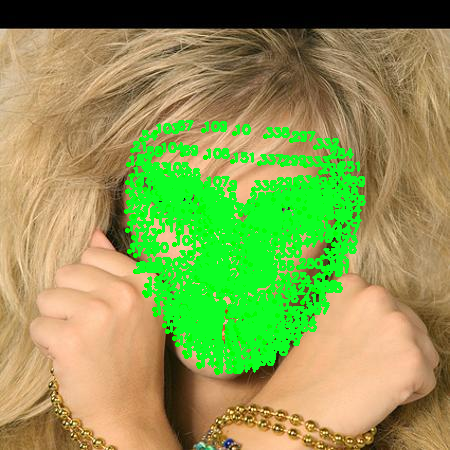

In [8]:
# Trinng face_mesh module in our imaes 
faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread(mylist_img[0])
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for j,landmark in enumerate(face.landmark):
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
              cv2.putText(image, str(j), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (36,255,12), 2)
      cv2_imshow(image)

In [9]:

# Define a function to grap all points from each image in one numpy arry 
def Points_from_an_image (image_Path_jpg):
  # creating an object from face detection model
  faceModule = mediapipe.solutions.face_mesh
  #using our modle in  one image by passig image path 
  with faceModule.FaceMesh(static_image_mode=True) as faces:
      
      image = cv2.imread(image_Path_jpg)
      #extaracting face form image 
      results=faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      x=[]
      y=[]
      #extarcting points on the face in the image 
      if results.multi_face_landmarks != None:
          for points in results.multi_face_landmarks:
              for  p in points.landmark:
                shape = image.shape 
                relative_x = int(p.x * shape[1])
                relative_y = int(p.y * shape[0])
                x.append(relative_x)
                y.append(relative_y)
  Record=np.hstack([x,y])
  return Record 

In [10]:
# extracting the 3 angles from each mat file related to images 
def YaW_Pitch_Raw_from_image (image_Path_mat):
  mat = sio.loadmat(image_Path_mat)
  Yaw_Pitch_Roll=mat["Pose_Para"][0][:3]
  Record_out=np.hstack([Yaw_Pitch_Roll])
  return Record_out


In [11]:
# using the previous 2 functions to extract all data from all images and sve them in numpy array 
Data=np.array([])
for i in range(len(mylist_mat)) :
  try:
    if i==0:
      Record = Points_from_an_image (mylist_img[i])
      Record_out=YaW_Pitch_Raw_from_image (mylist_mat[i])
      R=np.hstack((Record,Record_out))
      Data=np.hstack((Data,R))
    else:
      Record = Points_from_an_image (mylist_img[i])
      Record_out=YaW_Pitch_Raw_from_image (mylist_mat[i])
      R=np.hstack((Record,Record_out))
      Data=np.vstack([Data,R])
      print(Data.shape)
  except :
          pass


(2, 939)
(3, 939)
(4, 939)
(5, 939)
(6, 939)
(7, 939)
(8, 939)
(9, 939)
(10, 939)
(11, 939)
(12, 939)
(13, 939)
(14, 939)
(15, 939)
(16, 939)
(17, 939)
(18, 939)
(19, 939)
(20, 939)
(21, 939)
(22, 939)
(23, 939)
(24, 939)
(25, 939)
(26, 939)
(27, 939)
(28, 939)
(29, 939)
(30, 939)
(31, 939)
(32, 939)
(33, 939)
(34, 939)
(35, 939)
(36, 939)
(37, 939)
(38, 939)
(39, 939)
(40, 939)
(41, 939)
(42, 939)
(43, 939)
(44, 939)
(45, 939)
(46, 939)
(47, 939)
(48, 939)
(49, 939)
(50, 939)
(51, 939)
(52, 939)
(53, 939)
(54, 939)
(55, 939)
(56, 939)
(57, 939)
(58, 939)
(59, 939)
(60, 939)
(61, 939)
(62, 939)
(63, 939)
(64, 939)
(65, 939)
(66, 939)
(67, 939)
(68, 939)
(69, 939)
(70, 939)
(71, 939)
(72, 939)
(73, 939)
(74, 939)
(75, 939)
(76, 939)
(77, 939)
(78, 939)
(79, 939)
(80, 939)
(81, 939)
(82, 939)
(83, 939)
(84, 939)
(85, 939)
(86, 939)
(87, 939)
(88, 939)
(89, 939)
(90, 939)
(91, 939)
(92, 939)
(93, 939)
(94, 939)
(95, 939)
(96, 939)
(97, 939)
(98, 939)
(99, 939)
(100, 939)
(101, 939)
(102, 

In [12]:
#making DataFrame from Data array 
Data=pd.DataFrame(data=Data, columns=columns)

In [13]:
# Creating Backup Dataset
Data_Back=Data.copy()

In [14]:
Data

,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,Y_461,Y_462,Y_463,Y_464,Y_465,Y_466,Y_467,Pitch,Yaw,Roll
0,218.0,220.0,220.0,215.0,220.0,222.0,226.0,163.0,228.0,229.0,...,289.0,290.0,218.0,221.0,225.0,212.0,208.0,-0.399231,0.018227,0.085676
1,198.0,187.0,201.0,196.0,187.0,192.0,208.0,208.0,213.0,212.0,...,270.0,272.0,228.0,230.0,231.0,225.0,222.0,0.470065,1.189533,0.300959
2,143.0,144.0,143.0,139.0,144.0,144.0,142.0,111.0,141.0,141.0,...,350.0,350.0,323.0,324.0,325.0,320.0,319.0,-0.184650,0.881137,-0.236852
3,226.0,211.0,220.0,199.0,207.0,205.0,203.0,162.0,196.0,192.0,...,293.0,293.0,225.0,229.0,233.0,205.0,200.0,-0.175379,0.299208,-0.373374
4,229.0,221.0,224.0,210.0,219.0,217.0,213.0,161.0,210.0,208.0,...,274.0,276.0,216.0,219.0,221.0,203.0,201.0,-0.026812,0.011965,-0.220662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,231.0,239.0,233.0,230.0,240.0,239.0,234.0,162.0,233.0,234.0,...,283.0,284.0,223.0,226.0,228.0,215.0,213.0,-0.306358,-0.283822,0.038554
1849,244.0,254.0,247.0,245.0,255.0,255.0,250.0,179.0,250.0,251.0,...,288.0,288.0,221.0,225.0,227.0,215.0,211.0,-0.367547,-0.429723,0.122791
1850,263.0,271.0,267.0,271.0,274.0,276.0,281.0,228.0,286.0,290.0,...,287.0,289.0,241.0,242.0,243.0,246.0,243.0,-0.156035,0.567114,-0.108536
1851,221.0,225.0,223.0,220.0,226.0,227.0,231.0,159.0,233.0,234.0,...,289.0,290.0,220.0,223.0,226.0,216.0,213.0,-0.197102,-0.070430,0.105118


Data Preprocessing 

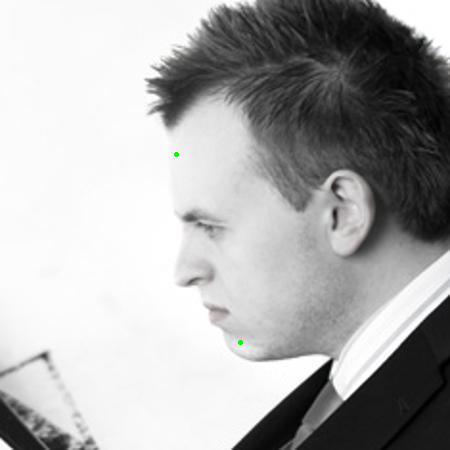

In [15]:
# in this cell we try to investigate on data set to decide which points to be choosen as centre 
# and what to be chossen as rescaling points 
D=Data.iloc[4,0:936]
image = cv2.imread(mylist_img[4])
j=109
k=200
cv2.circle(image, (int(D[j]), int(D[j+468])), radius=1, color=(0, 255, 0), thickness=2)
cv2.circle(image, (int(D[k]), int(D[k+468])), radius=1, color=(0, 255, 0), thickness=2)
cv2_imshow(image)

In [16]:
# choosing point to center other points around 
Data["OriginX"]=Data.X_1

In [17]:
#choosing point to center other points around 
Data["OriginY"]=Data.Y_1

In [18]:
#ymax=Data.drop(columns=["Yaw","Pitch","Roll","OriginX","OriginY"]).describe().loc["max"][468:]

In [19]:

#xmax=Data.drop(columns=["Yaw","Pitch","Roll","OriginX","OriginY"]).describe().loc["max"][0:468]

In [20]:
#max(xmax)

In [21]:
#max(ymax)

In [22]:
#min(xmax)

In [23]:
#min(ymax)

In [24]:
#xmax[xmax==377.0]

In [25]:
#xmax[xmax==488.0]

In [26]:
#ymax["Y_153"]

In [27]:
#ymax["Y_323"]

In [28]:
#ymax["Y_361"]

In [29]:
# center data around X_1 (X cordenate)
for i in (Data.iloc[:,:468].columns):
  Data[i]=Data[i]-Data["OriginX"]

In [30]:
# center data around X_1 (Y cordenate)
for i in (Data.iloc[:,468:936].columns):
  Data[i]=Data[i]-Data["OriginY"]

In [33]:
# Choose 2 points to rescale all points according to their distance 
ratio=(Data["X_200"]-Data["X_109"])**2+(Data["Y_200"]-Data["Y_109"])**2
ratio

0       50345.0
1       20168.0
2        8325.0
3       33625.0
4       39440.0
         ...   
1848    37225.0
1849    42930.0
1850    32882.0
1851    49348.0
1852    42050.0
Length: 1853, dtype: float64

In [34]:
#Calculate distance between point 109 ,point 200
R=[]
for i in ratio :
  R.append(math.sqrt(i))
Data["Ratio"]=pd.DataFrame(R)

In [35]:
# Normalizing all points (rescaling)
for i in (Data.iloc[:,:936].columns):
  Data[i]=Data[i]/Data["Ratio"]

In [36]:
Data

,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,Y_464,Y_465,Y_466,Y_467,Pitch,Yaw,Roll,OriginX,OriginY,Ratio
0,-0.008914,0.0,0.000000,-0.022284,0.000000,0.008914,0.026741,-0.254037,0.035654,0.040111,...,-0.294148,-0.276321,-0.334259,-0.352086,-0.399231,0.018227,0.085676,220.0,287.0,224.376915
1,0.077457,0.0,0.098582,0.063374,0.000000,0.035208,0.147873,0.147873,0.183080,0.176039,...,-0.253496,-0.246454,-0.288704,-0.309828,0.470065,1.189533,0.300959,187.0,266.0,142.014084
2,-0.010960,0.0,-0.010960,-0.054800,0.000000,0.000000,-0.021920,-0.361678,-0.032880,-0.032880,...,-0.273998,-0.263038,-0.317838,-0.328798,-0.184650,0.881137,-0.236852,144.0,349.0,91.241438
3,0.081801,0.0,0.049081,-0.065441,-0.021814,-0.032721,-0.043627,-0.267218,-0.081801,-0.103615,...,-0.354472,-0.332659,-0.485354,-0.512621,-0.175379,0.299208,-0.373374,211.0,294.0,183.371208
4,0.040283,0.0,0.015106,-0.055389,-0.010071,-0.020141,-0.040283,-0.302122,-0.055389,-0.065460,...,-0.266875,-0.256804,-0.347441,-0.357511,-0.026812,0.011965,-0.220662,221.0,272.0,198.595065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,-0.041464,0.0,-0.031098,-0.046647,0.005183,0.000000,-0.025915,-0.399092,-0.031098,-0.025915,...,-0.285066,-0.274700,-0.342079,-0.352445,-0.306358,-0.283822,0.038554,239.0,281.0,192.937814
1849,-0.048264,0.0,-0.033785,-0.043437,0.004826,0.004826,-0.019305,-0.361977,-0.019305,-0.014479,...,-0.289581,-0.279929,-0.337845,-0.357151,-0.367547,-0.429723,0.122791,254.0,285.0,207.195560
1850,-0.044117,0.0,-0.022059,0.000000,0.016544,0.027573,0.055147,-0.237132,0.082720,0.104779,...,-0.220587,-0.215073,-0.198529,-0.215073,-0.156035,0.567114,-0.108536,271.0,282.0,181.333946
1851,-0.018006,0.0,-0.009003,-0.022508,0.004502,0.009003,0.027009,-0.297104,0.036013,0.040514,...,-0.283600,-0.270095,-0.315111,-0.328616,-0.197102,-0.070430,0.105118,225.0,286.0,222.144097


In [37]:
Data=Data.drop(columns=["OriginX","OriginY","Ratio"])

In [38]:
Yaw_Data=Data.drop(columns=["Roll","Pitch"])

In [39]:
Roll_Data=Data.drop(columns=["Pitch","Yaw"])

In [40]:
Pitch_Data=Data.drop(columns=["Roll","Yaw"])

In [41]:
# Train Test split our data to impelement our model 
#split Yaw Data
X_train_Yaw, X_test_Yaw, Y_train_Yaw, Y_test_Yaw = train_test_split(
    Yaw_Data.drop(columns=["Yaw"]), Yaw_Data["Yaw"], test_size=0.20, random_state=1)

In [42]:
#split Pitch Data
X_train_Roll, X_test_Roll, Y_train_Roll, Y_test_Roll = train_test_split(
    Roll_Data.drop(columns=["Roll"]), Roll_Data["Roll"], test_size=0.20, random_state=1)

In [43]:
#split Roll Data
X_train_Pitch, X_test_Pitch, Y_train_Pitch, Y_test_Pitch = train_test_split(
    Pitch_Data.drop(columns=["Pitch"]), Pitch_Data["Pitch"], test_size=0.20, random_state=1)



model impelementation 




---



---






In [494]:
# using grid search to get best model parameters 
Clf1=SVR()
search_space={"C":list(range(1,100,1)),"kernel":["rbf","ploy"],"gamma":["scale","auto",0.5,0.9,1]}
GS1=GridSearchCV(Clf1,param_grid=search_space,scoring="neg_mean_absolute_error",cv=5,verbose=False)
# Trainig model to predict Yaw angle 
GS1.fit(X_train_Yaw, Y_train_Yaw)
GS1.best_params_

{'C': 81, 'gamma': 'auto', 'kernel': 'rbf'}

In [44]:
# bulding SVR model to predict Yaw angle depends on grid search results 
Clf1_b=SVR(C=8, gamma='scale', kernel= 'rbf')
Clf1_b.fit(X_train_Yaw, Y_train_Yaw)
Y_train_predict=Clf1_b.predict(X_train_Yaw)
#print(X_train_Yaw.to_numpy().reshape(-1,1))
#print(Y_train_predict.reshape(-1,1))
mean_absolute_error(Y_train_predict,Y_train_Yaw)


0.06442561907153023

In [45]:
Clf1_b.score(X_train_Yaw,Y_train_Yaw.to_numpy().reshape(-1,1))

0.9383166166459875

In [46]:
Y_test_predict=Clf1_b.predict(X_test_Yaw)
mean_absolute_error(Y_test_predict,Y_test_Yaw)

0.08968271446182689

In [47]:
Clf1_b.score(X_test_Yaw,Y_test_Yaw.to_numpy().reshape(-1,1))

0.6999401068586308

In [499]:
# using grid search to get best model parameters 
Clf2=SVR()
search_space={"C":list(range(1,100,1)),"kernel":["rbf","ploy"],"gamma":["scale","auto",0.5,0.9,1]}
GS2=GridSearchCV(Clf2,param_grid=search_space,scoring="neg_mean_absolute_error",cv=5,verbose=False)
# Trainig model to predict Yaw angle 
GS2.fit(X_train_Pitch, Y_train_Pitch)
GS2.best_params_

{'C': 25, 'gamma': 'scale', 'kernel': 'rbf'}

In [48]:
# Trainig model to predict Pitch angle depends on grid search best parameters 
Clf2=SVR(kernel="rbf",C=25,gamma="scale")
Clf2.fit(X_train_Pitch, Y_train_Pitch)
Y_train_predict=Clf2.predict(X_train_Pitch)
#print(X_train_Yaw.to_numpy().reshape(-1,1))
#print(Y_train_predict.reshape(-1,1))
mean_absolute_error(Y_train_predict,Y_train_Pitch)

0.08796355278108303

In [49]:
Clf2.score(X_train_Pitch,Y_train_Pitch.to_numpy().reshape(-1,1))

0.25956709507812803

In [50]:
Y_test_predict=Clf2.predict(X_test_Pitch)
mean_absolute_error(Y_test_predict,Y_test_Pitch)

0.12170489814228151

In [53]:
# using grid search to get best model parameters 
Clf3=SVR()
search_space={"C":list(range(1,100,1)),"kernel":["rbf","ploy"],"gamma":["scale","auto",0.5,0.9,1]}
GS3=GridSearchCV(Clf3,param_grid=search_space,scoring="neg_mean_absolute_error",cv=5,verbose=False)
# Trainig model to predict Yaw angle 
GS3.fit(X_train_Roll, Y_train_Roll)
GS3.best_params_


{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

In [51]:
# Trainig SVR model to predict Pitch angle depends on grid search best parameters 
Clf3=SVR(kernel="rbf",C=1,gamma="scale")
Clf3.fit(X_train_Roll, Y_train_Roll)
Y_train_predict=Clf3.predict(X_train_Roll)
#print(X_train_Yaw.to_numpy().reshape(-1,1))
#print(Y_train_predict.reshape(-1,1))
mean_absolute_error(Y_train_predict,Y_train_Roll)

0.06848002050493925

In [52]:
Y_test_predict=Clf3.predict(X_test_Roll)
mean_absolute_error(Y_test_predict,Y_test_Roll)

0.11080664294312756

In [53]:
# Testing model in a Vedio 
cap = cv2.VideoCapture('/content/drive/MyDrive/Head Pose E video /New Project.mp4')
width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video file")

# initializing a list to store the frames   
Frames= []
# Read until video is completed
while(cap.isOpened()):   
  # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
      with faceModule.FaceMesh(static_image_mode=True) as face:
        # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
        results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None:
          for face in results.multi_face_landmarks:
              # initializing X and Y lists to store the spacial coordinates of the points
              X = []
              Y = []
              # looping over the landmarks to extract x and y
              for landmark in (face.landmark):
                  x = landmark.x
                  y = landmark.y
                  # retrieve the true values of x and y
                  shape = frame.shape 
                  relative_x = int(x * shape[1])
                  relative_y = int(y * shape[0])
                  X.append(relative_x)
                  Y.append(relative_y)

              X = np.array(X)
              Y = np.array(Y)
              # Ceter all poiints arround p[1]
              X_center = X - X[1]
              Y_center = Y - Y[1]
              Distance = np.linalg.norm(np.array((X[200],Y[200])) - np.array((X[109],Y[109])))
              Xnormal = X_center/Distance
              Ynormal = Y_center/Distance
              points = np.hstack([Xnormal,Ynormal]).reshape(1,-1)
              # predicting the 3 angels to draw the axis on the image
              Pitch = Clf2.predict(points)
              Yaw = Clf1_b.predict(points)
              Roll = Clf3.predict(points)
              
              draw_axis(frame,Pitch,Yaw,Roll,X[1],Y[1])
              # appending the result frame to the Frames List 
              Frames.append(frame)
    # Break the loop
    else: 
        break
cap.release()  
# Closes all the frames
cv2.destroyAllWindows()
# converting the frames to video
out = cv2.VideoWriter('out.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))
for i in range(len(Frames)):
  out.write(Frames[i])
out.release()